In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import h5py

import holodeck as holo
import holodeck.single_sources as ss
from holodeck.constants import YR, MSOL
from holodeck import utils, detstats, plot


import hasasia.sensitivity as hsen
import hasasia.sim as hsim

# Plotting functions

In [2]:
def plot_sample_nn(fobs, hc_ss, hc_bg, dp_ss, dp_bg, df_ss, df_bg, nn):
    """ Plot strain and detection probability for a single sample.
    """
    shape = hc_ss.shape
    F, R, L = shape[0], shape[1], shape[2]
    S = dp_ss.shape[-1]
    fig, axs = plt.subplots(1, 2,figsize=(12,4))

    # Strains
    plot.draw_ss_and_gwb(axs[0], fobs*YR, hc_ss, hc_bg)
    axs[0].set_xlabel(plot.LABEL_GW_FREQUENCY_YR)
    axs[0].set_ylabel(plot.LABEL_CHARACTERISTIC_STRAIN)
    axs[0].set_title('Sample nn=%d (F=%d, R=%d, L=%d)' % (nn, F, R, L))
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    for ss in range(S):
        axs[1].scatter(np.arange(nreals), dp_ss[:,ss], alpha=0.25)
    axs[1].scatter(np.arange(nreals), dp_bg, color='k', 
                   label='BG, DF = %.2e' % df_bg,
                   marker='d')
    axs[1].errorbar(np.arange(nreals), np.mean(dp_ss[:,:], axis=1),
                     yerr = np.std(dp_ss[:,:], axis=1), color='orangered',
                      label = 'SS, sky-avg, DF = %.2e' % df_ss, linestyle='', capsize=3,
                       marker='o' )
    axs[1].set_xlabel('Realization (R)')
    axs[1].set_ylabel('SS DetProb')
    # axs[1].set_title('BG DF = ' %nn)
    fig.legend()
    fig.tight_layout()
    
    return fig
# nn=7
# fig = plot_sample_nn(fobs, hc_ss_all[nn], hc_bg_all[nn], 
#                      dp_ss_psr40[nn], dp_bg_psr40[nn],
#                      df_ss_psr40[nn], df_bg_psr40[nn], 
#                      nn)

In [3]:
def plot_detprob(dp_ss_all, dp_bg_all):
    """ Plot detection probability for many samples.

    Paramaters
    ----------
    dp_ss_all : (N,R) NDarray
    dp_bg_all : (N,R,S) NDarray
    """
    fig, ax = plt.subplots(figsize=(6.5,4))
    ax.set_xlabel('Param Space Sample')
    ax.set_ylabel('Detection Probability, $\gamma$')
    ax.errorbar(np.arange(nsamp), np.mean(dp_bg_all, axis=1), 
                yerr = np.std(dp_bg_all, axis=1), linestyle='', 
                marker='d', capsize=5, color='cornflowerblue', alpha=0.75,
                label = r'$\langle \gamma_\mathrm{BG} \rangle$')
    ax.errorbar(np.arange(nsamp), np.mean(dp_ss_all, axis=(1,2)),
                yerr = np.std(dp_ss_all, axis=(1,2)), linestyle='', 
                marker='o', capsize=5, color='orangered', alpha=0.75,
                label = r'$\langle \gamma_\mathrm{SS} \rangle$')
    ax.set_yscale('log')
    ax.set_title('Average DP across Realizations')

    ax.legend()
    fig.tight_layout()

    return fig

# fig = plot_detprob(dp_ss_all, dp_bg_all)

In [4]:
def plot_detfrac(df_ss, df_bg, thresh):
    fig, ax = plt.subplots(figsize=(6.5,4))
    ax.plot(np.arange(nsamp), df_bg, color='cornflowerblue', label='BG',
            marker='d')
    ax.plot(np.arange(nsamp), df_ss, color='orangered', label='SS',
            marker='o')
    ax.set_xlabel('Param Space Sample')
    ax.set_ylabel('Detection Fraction')
    ax.set_title('Fraction of Realizations with DP > %0.2f' % thresh)
    ax.legend()
    fig.tight_layout()
    return fig

In [5]:
def plot_nsample_dp(dp_ss, dp_bg, nn):
    fig, ax = plt.subplots(figsize=(6.5,4))
    for ss in range(nskies):
        ax.scatter(np.arange(nreals), dp_ss_psr40[nn,:,ss], alpha=0.5)
    ax.scatter(np.arange(nreals), dp_bg_psr40[nn], color='k')
    ax.set_xlabel('Realization (R)')
    ax.set_ylabel('SS DetProb')
    ax.set_title('Sample (N): %d' %nn)
    return fig
    

# fig = plot_nsample_dp(dp_ss_psr40, dp_bg_psr40, nn=7)
# fig = plot.plot_bg_ss(fobs, hc_bg_all[nn], hc_ss_all[nn])

## Goal:
Pass in an hdf5 file from a library of param spaces and return the average detection probability.

## Steps:
1) Read in file: fobs, hc_ss, hc_bg
2) Produce a PTA set-up calibrated to 50% hc_bg DP?
3) Given pulsar setup and hdf file, calculate average ss DP and average bg DP
    * Calculate bg DP for each of R strain realizations
    * Build S sky realizations
    * Calculate ss DP for each of S sky realizations for each of R strain realizations.


# Step 1. Read in hdf file

In [6]:
filepath = '/Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss15_n100_r30_f100_d15_l5_p0/'
filename = filepath+'ss_lib.hdf5'
ssfile = h5py.File(filename, 'r')
print(list(ssfile.keys()))
# print(ssfile['pta_dur'][0])
fobs = ssfile['fobs'][:]
dfobs = ssfile['dfobs'][:]
dur = ssfile['pta_dur'][0]
cad = ssfile['pta_cad'][0]
hc_ss_all = ssfile['hc_ss'][...]
hc_bg_all = ssfile['hc_bg'][...]
shape = hc_ss_all.shape
nsamp, nfreqs, nreals, nloudest = shape[0], shape[1], shape[2], shape[3]
print(nsamp, nfreqs, nreals, nloudest)
ssfile.close()

['dfobs', 'fit_plaw', 'fit_plaw_med', 'fit_plaw_nbins', 'fit_turn', 'fit_turn_med', 'fit_turn_nbins', 'fobs', 'hc_bg', 'hc_ss', 'pta_cad', 'pta_dur', 'sample_params']
100 100 30 5


In [7]:
print('samples (N):', nsamp, '\nreals (R):', nreals, '\nN,F,R,L:', hc_ss_all.shape)

samples (N): 100 
reals (R): 30 
N,F,R,L: (100, 100, 30, 5)


# Step 2. Calibrate PTA??
Skipping this, picking 40 psrs with sigma 1e-7

# Step 3. Build PTA, Build skies, Calculate DP, Calculate DF
Step 2 was skipped, we didn't calibrate the PTA. Just built one randomly.

In [12]:
def run_psr_calculations_and_plot(hc_ss_all, hc_bg_all, npsrs, sigma, nskies = 25, thresh=0.5,
                                  detstatspath='./'):
    """ Calculate DPs for a set of randomly placed pulsars with the number and range given.

    Parameters
    ----------

    Returns
    -------
    
    """
    shape = hc_ss_all.shape
    nsamp, nfreqs, nreals, nloudest = shape[0], shape[1], shape[2], shape[3]

    # build PTA
    print('building psrs')
    phis = np.random.uniform(0, 2*np.pi, size = npsrs)
    thetas = np.random.uniform(np.pi/2, np.pi/2, size = npsrs)
    # sigmas = np.ones_like(phis)*sigma
    psrs = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigma,
                    phi=phis, theta=thetas)

     # Build ss skies
    print('building ss skies')
    theta_ss, phi_ss, Phi0_ss, iota_ss, psi_ss = _build_skies(nfreqs, nskies, nloudest)

    # Calculate DPs 
    print('calculating SS and BG detections probabilities')
    dp_bg_all = np.zeros((nsamp, nreals)) # (N,R)
    dp_ss_all = np.zeros((nsamp, nreals, nskies)) # (N,R,S)
    df_bg_all = np.zeros(nsamp)
    df_ss_all = np.zeros(nsamp)
    for nn in range(nsamp):
        print('on nn/N = %d/%d' % (nn,nsamp))
        dp_bg_all[nn,:] = detstats.detect_bg_pta(psrs, fobs, cad, hc_bg_all[nn])
        dp_ss_all[nn,:,:] = detstats.detect_ss_pta(psrs, cad, dur, fobs, dfobs,
                                                hc_ss_all[nn], hc_bg_all[nn],
                                                theta_ss=theta_ss, phi_ss=phi_ss, Phi0_ss=Phi0_ss,
                                                iota_ss=iota_ss, psi_ss=psi_ss)
        count_bg = 0
        count_ss = 0
        for rr in range(nreals):
            if (dp_bg_all[nn,rr] > thresh):
                count_bg += 1
            for ss in range(nskies):
                if (dp_ss_all[nn,rr,ss] > thresh):
                    count_ss += 1
        df_bg_all[nn] = count_bg/nreals
        df_ss_all[nn] = count_ss/(nreals*nskies)

        fig = plot_sample_nn(fobs, hc_ss_all[nn], hc_bg_all[nn],
                         dp_ss_all[nn], dp_bg_all[nn], 
                         df_ss_all[nn], df_bg_all[nn], nn=nn)
        fname = (detstatspath+'p%06d_detprob.png' % nn) # need to make this directory
        print(fname)
        fig.savefig(fname, dpi=100)
        plt.close(fig)

    return dp_ss_all, dp_bg_all, df_ss_all, df_bg_all



def _build_skies(nfreqs, nskies, nloudest):
    theta_ss = np.random.uniform(0, np.pi, size = nfreqs * nskies * nloudest).reshape(nfreqs, nskies, nloudest)
    phi_ss = np.random.uniform(0, 2*np.pi, size = theta_ss.size).reshape(theta_ss.shape)
    Phi0_ss = np.random.uniform(0,2*np.pi, size = theta_ss.size).reshape(theta_ss.shape)
    iota_ss = np.random.uniform(0,  np.pi, size = theta_ss.size).reshape(theta_ss.shape)
    psi_ss = np.random.uniform(0,   np.pi, size = theta_ss.size).reshape(theta_ss.shape)
    return theta_ss, phi_ss, Phi0_ss, iota_ss, psi_ss
        



building psrs
building ss skies
calculating SS and BG detections probabilities
on nn/N = 0/100
/Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss15_n100_r30_f100_d15_l5_p0/detstats2/p000000_detprob.png
on nn/N = 1/100
/Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss15_n100_r30_f100_d15_l5_p0/detstats2/p000001_detprob.png
on nn/N = 2/100
/Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss15_n100_r30_f100_d15_l5_p0/detstats2/p000002_detprob.png
on nn/N = 3/100
/Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss15_n100_r30_f100_d15_l5_p0/detstats2/p000003_detprob.png
on nn/N = 4/100
/Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss15_n100_r30_f100_d15_l5_p0/detstats2/p000004_detprob.png
on nn/N = 5/100
/Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss15_n100_r30_f100_d15_l5_p0/detstats2/p000005_detprob.png
on nn/N = 6/100
/Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss15_n100_r30_f100_d15_l5_p0/detstats2/p000006_detprob.png
on nn/N = 7/100
/U

TypeError: plot_detfrac() missing 1 required positional argument: 'thresh'

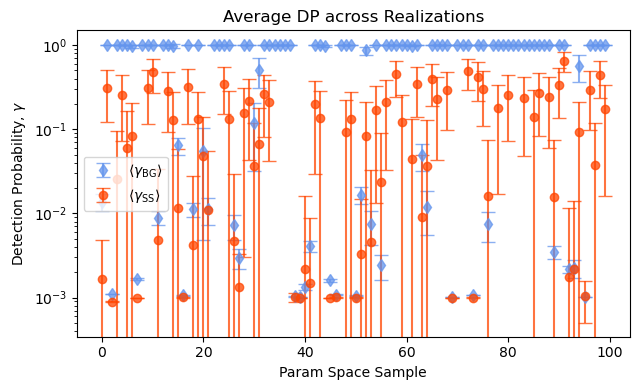

In [14]:
dp_ss2, dp_bg2, df_ss2, df_bg2 = run_psr_calculations_and_plot(hc_ss_all, hc_bg_all, npsrs = 40, sigma = 5e-7, 
                         nskies = 25, detstatspath=filepath+'detstats2/') # this is a pretty optimistic pta
fig1 = plot_detprob(dp_ss2, dp_bg2)
fig2 = plot_detfrac(df_ss2, df_bg2)

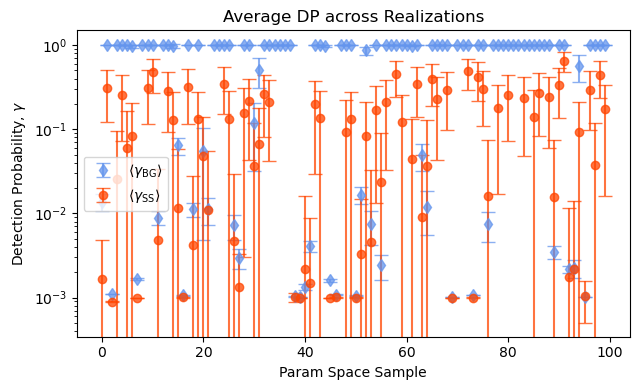

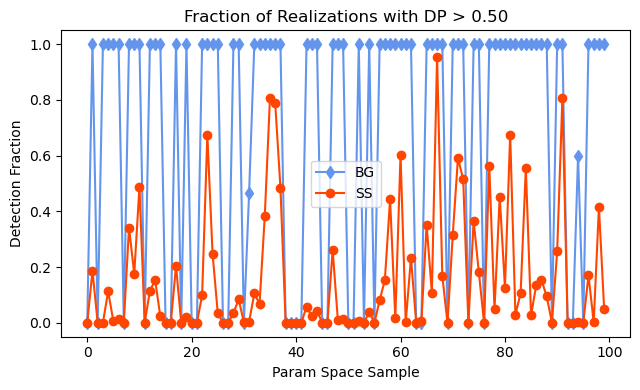

In [15]:
detstats_path = filepath+'/detstats/dp2_psrs40_sigma5e-7/'

fig1 = plot_detprob(dp_ss2, dp_bg2)
fig2 = plot_detfrac(df_ss2, df_bg2, thresh=0.5)
fig1.savefig(detstats_path+'allsamp_detprobs.png', dpi=300)
fig2.savefig(detstats_path+'allsamp_detfracs.png', dpi=300)
np.savez(detstats_path+'detstats.npz', dp_ss=dp_ss2, dp_bg=dp_bg2, 
         df_ss=df_ss2, df_bg=df_bg2)

In [ ]:
'''
def _detfrac_from_reals(dp_ss_all, dp_bg_all, thresh=0.5):
    """ 
    Calculate how many realizations have a detections, to get 
    the detection probability for a sample.

    Parameters
    ----------
    dp_ss_all : (N, R, S) NDarray
    dp_bg_all : (N, R) NDarray
    thresh : scalar
        threshold DP to count as a detection

    Returns
    -------
    ss_detfrac : (N,) NDarray
        Fraction of realizations with an ss DP above thresh.
    bg_detfrac : (N,) NDarray
        Fraction of realizations with a bg DP above thresh.

    NOTE: With minimal effort this can be done without for loops, 
    just needs some count() and condition array things
    """
    nsamp = len(dp_ss_all)
    nreals = len(dp_ss_all[0])
    nskies = len(dp_ss_all[0,0])
    bg_detfrac = np.zeros(nsamp)
    ss_detfrac = np.zeros(nsamp)
    for nn in range(nsamp):
        count_bg = 0
        count_ss = 0
        for rr in range(nreals):
            if (dp_bg_all[nn,rr] > thresh):
                count_bg += 1
            for ss in range(nskies):
                if (dp_ss_all[nn,rr,ss] > thresh):
                    count_ss += 1
        bg_detfrac[nn] = count_bg/nreals
        ss_detfrac[nn] = count_ss/(nreals*nskies)

    return ss_detfrac, bg_detfrac
'''